# Machine Learning Project - 13: **Sentiment Analysis on Twitter (Time Series Forecasting)**

**Install Libraries**

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn nltk tensorflow keras wordcloud

**Import Libraries**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


**Load the DataSet**

In [12]:
# Load dataset
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)

# Rename columns for clarity
df.columns = ["Sentiment", "ID", "Date", "Query", "User", "Tweet"]

# Drop unnecessary columns
df = df[["Sentiment", "Tweet"]]

# Map Sentiment: Convert 0 (Negative) to 0, and 4 (Positive) to 1
df["Sentiment"] = df["Sentiment"].map({0: 0, 4: 1})

# Display first few rows
print(df.head())

   Sentiment                                              Tweet
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


<ipython-input-12-e77604015909>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentiment"] = df["Sentiment"].map({0: 0, 4: 1})


**Data Preprocessing**

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

stop_words = set(stopwords.words('english'))

# Function to clean tweets
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Apply cleaning function to the dataset
df["Cleaned_Tweet"] = df["Tweet"].apply(clean_text)

# Display cleaned data
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   Sentiment                                              Tweet  \
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1          0  is upset that he can't update his Facebook by ...   
2          0  @Kenichan I dived many times for the ball. Man...   
3          0    my whole body feels itchy and like its on fire    
4          0  @nationwideclass no, it's not behaving at all....   

                                       Cleaned_Tweet  
0  switchfoot thats bummer shoulda got david carr...  
1  upset cant update facebook texting might cry r...  
2  kenichan dived many times ball managed save re...  
3                   whole body feels itchy like fire  
4           nationwideclass behaving im mad cant see  


**Visualize Data**

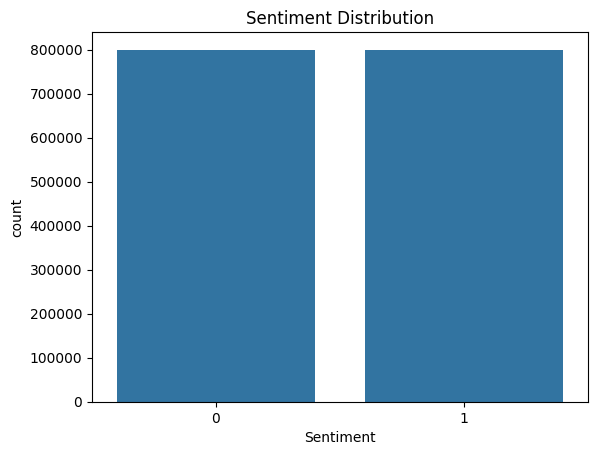

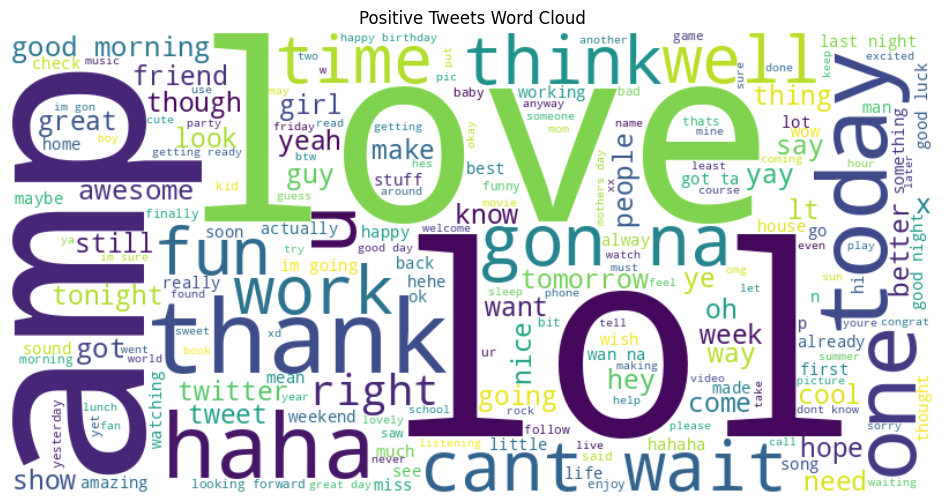

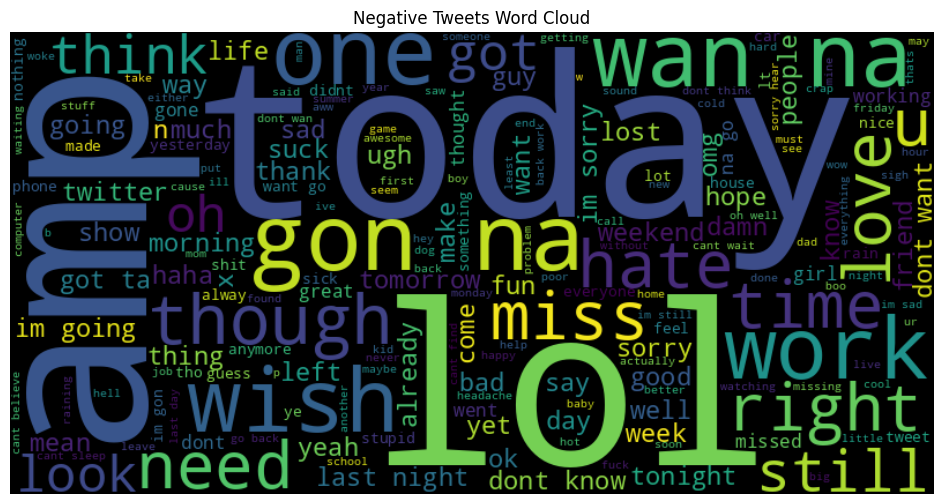

In [15]:
# Plot sentiment distribution
sns.countplot(x=df["Sentiment"])
plt.title("Sentiment Distribution")
plt.show()

# Generate a word cloud for positive and negative tweets
positive_tweets = " ".join(df[df["Sentiment"] == 1]["Cleaned_Tweet"])
negative_tweets = " ".join(df[df["Sentiment"] == 0]["Cleaned_Tweet"])

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_tweets)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Tweets Word Cloud")
plt.show()

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(negative_tweets)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Tweets Word Cloud")
plt.show()

**Split Data for Training & Testing**

In [16]:
X = df["Cleaned_Tweet"]
y = df["Sentiment"]

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

**Train a Machine Learning Model**

In [17]:
# Train Naïve Bayes model
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# Predictions
y_pred_nb = model_nb.predict(X_test)

# Evaluate Model
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naïve Bayes Accuracy: 0.757721875
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    159494
           1       0.76      0.75      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



**Train an LSTM Model**

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=100)

# Split into train and test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define LSTM model
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile model
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the LSTM model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))

# Predict using LSTM
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Evaluate LSTM Model
print("LSTM Accuracy:", accuracy_score(y_test_lstm, y_pred_lstm))
print(classification_report(y_test_lstm, y_pred_lstm))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 4861s 243ms/step - accuracy: 0.7627 - loss: 0.4867 - val_accuracy: 0.7857 - val_loss: 0.4512
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 4814s 241ms/step - accuracy: 0.7912 - loss: 0.4433 - val_accuracy: 0.7906 - val_loss: 0.4438
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 4824s 241ms/step - accuracy: 0.7988 - loss: 0.4298 - val_accuracy: 0.7922 - val_loss: 0.4417
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 4822s 241ms/step - accuracy: 0.8066 - loss: 0.4160 - val_accuracy: 0.7920 - val_loss: 0.4417
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8127 - loss: 0.4056

**Predict Sentiment on New Tweet**

In [3]:
def predict_sentiment(tweet, model, vectorizer=None, is_lstm=False):
    tweet = clean_text(tweet)
    if is_lstm:
        seq = tokenizer.texts_to_sequences([tweet])
        padded = pad_sequences(seq, maxlen=100)
        pred = model.predict(padded)
        return "Positive" if pred > 0.5 else "Negative"
    else:
        tweet_tfidf = vectorizer.transform([tweet])
        pred = model.predict(tweet_tfidf)
        return "Positive" if pred[0] == 1 else "Negative"

# Test predictions
tweet_example = "I love this product, it's amazing!"
print("Naïve Bayes Prediction:", predict_sentiment(tweet_example, model_nb, vectorizer))
print("LSTM Prediction:", predict_sentiment(tweet_example, model_lstm, is_lstm=True))


NameError: name 'model_nb' is not defined

**Save & Load the Model**

In [ ]:
# Save TF-IDF Model
import pickle
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save Naïve Bayes Model
with open("naive_bayes_model.pkl", "wb") as f:
    pickle.dump(model_nb, f)

# Save LSTM Model
model_lstm.save("lstm_sentiment_model.h5")

# Load Models
from tensorflow.keras.models import load_model

with open("tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("naive_bayes_model.pkl", "rb") as f:
    model_nb = pickle.load(f)

model_lstm = load_model("lstm_sentiment_model.h5")
